# DRILL: Random Forest, Third Attempt

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

df = pd.read_csv('https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1', skipinitialspace=True, header=1)
df.head()

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [15]:
print(df.shape)
df = df[:50000]

(421097, 111)


## First Attempt

In [3]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i, column.nunique())

id 0
term 2
int_rate 70
grade 7
sub_grade 35
emp_title 21288
emp_length 11
home_ownership 4
verification_status 3
issue_d 2
loan_status 7
pymnt_plan 2
desc 3
purpose 12
title 12
zip_code 856
addr_state 49
earliest_cr_line 605
revol_util 1083
initial_list_status 2
last_pymnt_d 29
next_pymnt_d 2
last_credit_pull_d 30
application_type 2
verification_status_joint 1
hardship_flag 2
hardship_type 1
hardship_reason 9
hardship_status 3
hardship_start_date 14
hardship_end_date 15
payment_plan_start_date 14
hardship_loan_status 4
disbursement_method 1
debt_settlement_flag 2
debt_settlement_flag_date 19
settlement_status 3
settlement_date 24


In [4]:
# Convert ID and Interest Rate to numeric.
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df['int_rate'] = pd.to_numeric(df['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
df.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [5]:
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
49995,NaN,NaN,13200.0,13200.0,13200.0,60 months,18.20,336.64,E,< 1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49996,NaN,NaN,6000.0,6000.0,6000.0,36 months,11.49,197.83,B,2 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49997,NaN,NaN,24000.0,24000.0,24000.0,36 months,10.99,785.62,B,8 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49998,NaN,NaN,12000.0,12000.0,12000.0,36 months,10.99,392.81,B,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49999,NaN,NaN,12525.0,12525.0,12525.0,36 months,5.32,377.19,A,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df[:-2]
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
49993,NaN,NaN,25200.0,25200.0,25200.0,60 months,20.99,681.61,E,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49994,NaN,NaN,10000.0,10000.0,10000.0,36 months,10.99,327.34,B,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49995,NaN,NaN,13200.0,13200.0,13200.0,60 months,18.20,336.64,E,< 1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49996,NaN,NaN,6000.0,6000.0,6000.0,36 months,11.49,197.83,B,2 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
49997,NaN,NaN,24000.0,24000.0,24000.0,36 months,10.99,785.62,B,8 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Second Attempt

In [7]:
rfc = ensemble.RandomForestClassifier()
X = df.drop('loan_status', 1)
Y = df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

# TODO: Understand why column count is going down so dramatically from 137 to 12
# TODO: Get rid of id, member_id, etc.
# TODO: Make sure you know what coluns are being dropped when you drop nans
# TODO: in future, make sure text columns are converted to categorical / numeric / continuous

cross_val_score(rfc, X, Y, cv=5)

array([ 0.985006  ,  0.985     ,  0.98579716,  0.98429686,  0.98389678])

## Third Attempt

Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [8]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'emp_length',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=137)

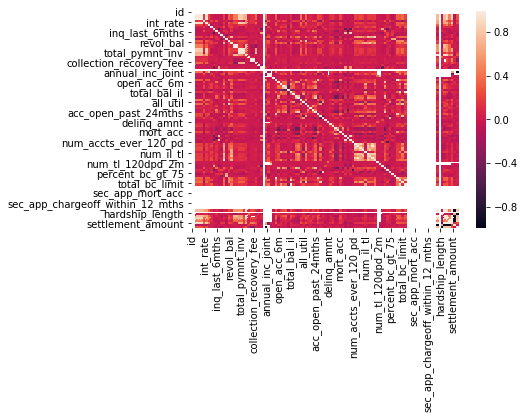

In [9]:
sns.heatmap(df.corr())
# REMINDER: correlation matrices do not work for categorical (so no point in doing these correlation matrices)
# May just show that I need to do PCA to get rid of unnecessary features that are highly correlated with others

# YOU CAN test for multicollinearity, but it doesn't matter for random forest
# random forest is NOT affected by multicollinearity (will just vote for whatever the 2 correlated features say target should be)

# TO test effectiveness on categorical target

# T test will help you see both:
# distribution of data for different categories is significantly different? T-test
# difference in categories' averages? (using standard deviation as welll)


# effective of category on category - chi square (REVIEW)
# effect of category on continuous - t-test / z-test

# ensemble model:
# random forest – each decision tree gets to vote on the response / target

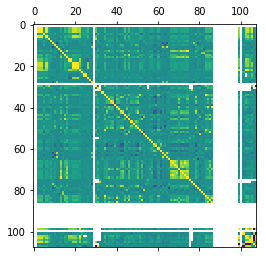

In [10]:
plt.matshow(df.corr())

In [11]:
# TODO: 
# DO NOT INCLUDE INDICES IN YOUR MODEL (DOES NOT ADD ANY INFO)
# 

In [12]:
from sklearn.decomposition import PCA
# TODO: Make sure I have more than 12 features to begin with (20?)
# Make sure I am actually 
# 15, 10, 11 / 12
# Try below 10 (to see if it goes up)

pca = PCA(n_components=12)
principal_components = pca.fit_transform(X)

In [13]:
rfc = ensemble.RandomForestClassifier()
X = df.drop('loan_status', 1)
Y = df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)
X = principal_components

cross_val_score(rfc, X, Y, cv=5)

array([ 0.96391443,  0.9645    ,  0.964993  ,  0.96289258,  0.96519304])